![Lapage](Lapage_logo.png)
# Contexte
Lapage était originellement une librairie physique avec plusieurs points de vente. 
Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne. 
Vous intervenez car l’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc.

# Missions
- Réaliser une analyse des différents indicateurs de vente :
    - Le CA (indicateurs et graphiques) et son évolution dans le temps via la mise en place d'une décomposition en moyenne mobile pour évaluer la tendance globale;
    - Zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.;
    - Focus sur les profils des clients, et également la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz.
- Fournir une analyse plus ciblée sur les clients : l’objectif serait cette fois-ci de comprendre le comportement de nos clients en ligne, pour pouvoir ensuite comparer avec la connaissance acquise via nos librairies physiques. 
    - Etablir le lien entre le genre d’un client et les catégories des livres achetés.
    - Faire divers corrélations entre l’âge des clients et le montant total des achats, la fréquence d’achat, la taille du panier moyen et les catégories des livres achetés.



# Préparation des données 

## Initialisation du projet

### Import des librairies

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Paramètres

In [185]:
%matplotlib inline 
# On indique que l'on veut voir apparaître les graphiques dans le notebook, sinon on ne verrait rien

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

### Import des fichiers

In [186]:
path='./Fichiers csv/'
customers_df = pd.read_csv(path+"customers.csv")
products_df=pd.read_csv(path+"products.csv")
transactions_df=pd.read_csv(path+"transactions.csv")

### Variables ou classes

Avant de commencer, je stocke le nombre de lignes et de colonnes de chacun des fichiers

In [187]:
customers_initial_size=customers_df.shape
products_intial_size=products_df.shape
transactions_intial_size=transactions_df.shape

## Analyse de la qualité des données

In [217]:
customers_df

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8618,c_7920,m,1956
8619,c_7403,f,1970
8620,c_5119,m,1974
8621,c_5643,f,1968


In [218]:
products_df

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1


In [219]:
transactions_df

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232
...,...,...,...,...
679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227


### Erreurs de type

In [188]:
customers_df.dtypes

client_id    object
sex          object
birth         int64
dtype: object

In [189]:
products_df.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

In [190]:
transactions_df.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

**Observation**<br>
La seule chose qui semble être problématique est la variable date qui n'est pas considérée comme une date. <br>
On peut corriger cela via la fonction to_datetime de pandas. <br>

**Méthode**<br>
En lançant la commande de transformation du type object en date, on s'aperçoit que la conversion est bloquée par une erreur : "Unknown string format: test_2021-03-01 02:30:02.237419"<br>
Avant de relancer la conversion, j'identifie toutes les dates ayant le mot "test" et je les stocke dans un nouveau dataframe avant de les supprimer de mon fichier.
Je lance ensuite ma conversion au format date.

In [191]:
mask = np.column_stack([transactions_df["date"].str.contains("test", na=False) for col in transactions_df])
test_dates_transactions_df=transactions_df.loc[mask.any(axis=1)]
test_dates_transactions_df.head()

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0


In [192]:
transactions_df.drop(test_dates_transactions_df.index, inplace=True)

In [193]:
transactions_df.shape

(679332, 4)

In [194]:
transactions_df.date=pd.to_datetime(transactions_df.date)
transactions_df.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

### Valeurs manquantes

Je vérifier si mon jeu de données contient des valeurs manquantes (Null ou NaN)

In [195]:
customers_df.isnull().sum()| customers_df.isna().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [196]:
products_df.isnull().sum()| products_df.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [197]:
transactions_df.isnull().sum()| transactions_df.isna().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

**Observation**<br>
Il n'y a pas de valeurs NaN ou None

### Doublons

Pour identifier les doublons, je me base sur des clés qui ne devraient pas contenir d'informations en double<br>
- customer : le client_id doit être unique puisqu'il constitue la clé primaire;<br>
- products : le id_prod doit être unique puisqu'il constitue la clé primaire;<br>
- transactions : ce qui constituerait une transaction unique est l'ensemble id_prod + client_id + date.

In [198]:
customers_df.loc[customers_df["client_id"].duplicated(keep=False),:]

,client_id,sex,birth


In [199]:
transactions_df.loc[transactions_df[["id_prod","date","client_id"]].duplicated(keep=False)]

,id_prod,date,session_id,client_id


In [200]:
# à supprimer?
transactions_df.sort_values("session_id", ascending=False).loc[transactions_df["session_id"].duplicated(keep=False)]

,id_prod,date,session_id,client_id
599185,0_1604,2021-10-04 19:00:20.030388,s_99998,c_2795
48865,0_1411,2021-10-04 18:50:59.099942,s_99998,c_2795
633558,0_1572,2021-10-04 18:45:54.374885,s_99998,c_2795
218613,0_1475,2021-10-04 18:45:05.640783,s_99996,c_4900
671163,0_1609,2021-10-04 18:39:10.485474,s_99996,c_4900
...,...,...,...,...
142862,0_1625,2021-03-03 02:38:09.568389,s_1000,c_1014
377843,0_1590,2021-03-03 02:49:03.169115,s_1000,c_1014
87809,0_1438,2021-03-03 03:25:12.320225,s_1000,c_1014
360110,0_1030,2021-03-01 04:12:43.572994,s_100,c_3854


**Observation**<br>
Il n'y a pas de doublon dans les données

### Détection d'anomalies

Un describe peut potentiellement nous aider dans un premier temps.<br>

In [201]:
customers_df.describe(include="all")

,client_id,sex,birth
count,8623,8623,8623.000000
unique,8623,2,NaN
top,c_4410,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.280877
std,NaN,NaN,16.919535
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


**Observation**

Pour la table customer, rien ne semble anormal : Les années de naissances vont de 1929 à 2004, et il n'y a que 2 valeurs pour le sexe.<br>

In [202]:
products_df.describe(include="all")

,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,0_1421,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


**Observation**

On note que la plus faible valeur est négative. Sans présumer de la valeur des livres, un prix négatif est forcément une erreur.

Recherche de prix négatifs ou valant 0

In [203]:
products_df[products_df.price<=0]

,id_prod,price,categ
731,T_0,-1.0,0


Le prix négatif a un id différent des autres car incluant une lettre. On pourrait assumer qu'il s'agit d'une erreur et supprimer cette ligne.
Je vérifie avant si je retrouve ce produit dans la table transaction qui est liée à la table products.

In [204]:
transactions_df[transactions_df.id_prod=="T_0"]

,id_prod,date,session_id,client_id


Je vérifie en passant si ce produit se trouve dans la table de test.

In [205]:
test_dates_transactions_df[test_dates_transactions_df=="T_0"].count()

id_prod       200
date            0
session_id      0
client_id       0
dtype: int64

Le produit est un produit test, il n'est pas présent dans la table transactions nettoyée. Je supprime la ligne.

In [206]:
products_df.drop(products_df[products_df.price<=0].index, inplace=True)

### Conclusion

Un type de données a été modifié.<br>
Aucune valeur manquante identifiée.<br>
Aucun doublon n'a été détecté.<br>
Des lignes ont été supprimées :
 - Les lignes de tests
 - Les lignes contenant des prix négatifs


In [215]:
customers_final_size=customers_df.shape
products_final_size=products_df.shape
transactions_final_size=transactions_df.shape

print (f"""
Le fichier 'customers.csv' contenait initialiement {customers_initial_size[0]} lignes et {customers_initial_size[1]} colonnes. 
Il contient maintenant {customers_final_size[0]} lignes et {customers_final_size[1]} colonnes. 

Le fichier 'products.csv' contenait initialiement {products_intial_size[0]} lignes et {products_intial_size[1]} colonnes. 
Il contient maintenant {products_final_size[0]} lignes et {products_final_size[1]} colonnes. 

Le fichier 'transactions.csv' contenait initialiement {transactions_intial_size[0]} lignes et {transactions_intial_size[1]} colonnes. 
Il contient maintenant {transactions_final_size[0]} lignes et {transactions_final_size[1]} colonnes. 
""")


Le fichier 'customers.csv' contenait initialiement 8623 lignes et 3 colonnes. 
Il contient maintenant 8623 lignes et 3 colonnes. 

Le fichier 'products.csv' contenait initialiement 3287 lignes et 3 colonnes. 
Il contient maintenant 3286 lignes et 3 colonnes. 

Le fichier 'transactions.csv' contenait initialiement 679532 lignes et 4 colonnes. 
Il contient maintenant 679332 lignes et 4 colonnes. 



# Analyse des différents indicateurs de vente

Pour faciliter la lecture des données, je merge toutes les données dans un seul tableau. Le tableau "principal" est transactions car il a les 2 clés étrangères des 2 autres tables.

In [220]:
main_df=(
    transactions_df
        .merge(customers_df, how="left")
        .merge(products_df, how="left")
)
main_df

In [236]:
main_df.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
sex                   object
birth                  int64
price                float64
categ                float64
dtype: object

Le champ categ est devenu flaot au lieu d'un entier.<br>
Je force le type entier.

Ayant réalisé une jointure gauche, je vérifie s'il y a des lignes nulles

In [273]:
null_rows=main_df[main_df.isnull().any(axis=1)]                          
print(f"Il y a {len(null_rows)} transactions dont au moins une valeur est nulle.")
if int(len(null_rows.id_prod.unique())>1):
    print(f"{len(null_rows.id_prod.unique())} produits sont concernés : {','.join(str(i) for i in null_rows.id_prod.unique())}")
else:
    print(f"Le produit concerné est {''.join(null_rows.id_prod.unique())}") 

Il y a 221 transactions dont au moins une valeur est nulle.
Le produit concerné est 0_2245


In [275]:
null_rows.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,m,1940,NaN,NaN
10103,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,f,1963,NaN,NaN
11723,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,m,1978,NaN,NaN
15670,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,m,1991,NaN,NaN
16372,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,m,1973,NaN,NaN


In [284]:
len(main_df)

679332

In [238]:
main_df["categ"]=main_df.categ.astype('int')

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

# g

#### Calcul du z_score
Selon la formule (x-µ)/σ 
- x=valeur de la cellule
- µ=moyenne
- écart type

Méthode pour calculer les outliers :<br>
Pour des données supposées normalement distribuées, 95% de celles-ci se situent dans 2 écarts types, et 99.7% dans 3.
Comme on ne sait pas vraiment ce que l'on cherche, un seuil de 2 sera plus pertinent.

In [79]:
mean = np.mean(products_df.price)
std_dev=np.std(products_df.price)
products_df["Z_score"]=(products_df.price - mean)/std_dev

print(f"""
La moyenne des prix se positionne à {mean:.2f}€.
L'écart-type est de {std_dev:.2f}.
""")



La moyenne des prix se positionne à 21.86€.
L'écart-type est de 29.84.



Comme un prix est forcément positif, je ne regarde pas les valeurs inférieures à 2 fois l'écart type, mais uniquement les z_score supérieurs au seuil de 2 écarts types.
Puis, je calcule le seuil de prix à partir duquel une valeur est considérée comme un outlier : 
- (x-µ)/σ=seuil 
- soit x = seuil * σ + µ

Les prix négatifs ou valant 0 ont déjà été gérés.

In [112]:
zscore_threshold=2
zscore_outliers=products_df[products_df.Z_score > zscore_threshold]

zscore_outliers.sort_values("Z_score").tail()

,id_prod,price,categ,Z-Score,Z_score
2779,2_30,233.54,2,7.093146,7.093146
1436,2_167,236.99,2,7.208750,7.208750
394,2_158,247.22,2,7.551539,7.551539
724,2_76,254.44,2,7.793469,7.793469
947,2_2,300.00,2,9.320107,9.320107


In [102]:
price_outlier=zscore_threshold * std_dev + mean
print (f"""Le prix à partir duquel on peut soupçonner un prix, sur la base des autres prix, d'être un outlier est {price_outlier:.2f}€.
Il y a {len(zscore_outliers)} prix qui pourraient être vérifiés :
{zscore_outliers[["id_prod","price"]].sort_values("price")}
""")

Le prix à partir duquel on peut soupçonner un prix, sur la base des autres prix, d'être un outlier est 81.54€.
Il y a 157 prix qui pourraient être vérifiés :
     id_prod   price
272    2_139   82.99
1101    2_20   83.51
1854   2_174   83.63
420    2_137   83.99
2915   2_138   84.02
905     2_16   84.29
2446   2_186   84.96
3188    2_99   84.99
2371    2_51   84.99
1767   2_134   85.27
1696   2_180   85.28
2280   2_114   85.89
1009   2_219   86.99
422    2_201   86.99
767     2_81   86.99
1914   2_224   87.40
3006    2_68   88.29
199     2_71   88.99
2231   2_177   88.99
489     2_54   89.43
1094   2_218   89.54
2391   2_221   90.99
2549   2_204   91.82
2078    2_38   93.48
3196   2_238   93.92
918     2_53   93.99
754    2_118   96.56
3046    2_58   96.69
2004   2_154   96.74
2429    2_24   96.88
1925    2_91   96.99
1670    2_75   96.99
966     2_95   98.99
2363    2_65   99.99
1437   2_124  100.56
1536   2_205  100.99
2874     2_6  101.51
1999    2_25  101.99
3075   2_162  102.82
30

#### Calcul de l'écart interquartile

Selon la formule
Ecart interquartile = 3ème quartile - 1er quartile

Méthode pour calculer les outliers :<br>
Une valeur aberrante ou atypique dans une distribution est un nombre qui est plus d'une fois et demie la longueur de la boîte à l'écart du quartile inférieur ou supérieur.<br>
Si un nombre est inférieur à Q1 - 1,5×IQR ou supérieur à Q3 + 1,5×IQR, alors c'est une valeur aberrante.

In [128]:
median=np.median(products_df.price)
q1=np.median(products_df[products_df.price<=median]["price"])
q3=np.median(products_df[products_df.price>median]["price"])
iqr=q3-q1
outlier_q1=q1-(1.5*iqr)
outlier_q3=q3+(1.5*iqr)

print (f"""
La médiane des prix est égale à {median:.2f}€ : il y a autant de prix au dessus de ce montant qu'en dessous.
Le 1er quartile se situe à {q1:.2f}€.
Le troisième est situé à {q3:.2f}€.
L'écart interquartile vaut {iqr:.2f}€.
Les outliers se situent en dessous de {outlier_q1:.2f}€ et au dessus de {outlier_q3:.2f}€.
""")
        
       


La médiane des prix est égale à 13.07€ : il y a autant de prix au dessus de ce montant qu'en dessous.
Le 1er quartile se situe à 6.99€.
Le troisième est situé à 22.99€.
L'écart interquartile vaut 16.00€.
Les outliers se situent en dessous de -17.01€ et au dessus de 46.99€.



<AxesSubplot:xlabel='price'>

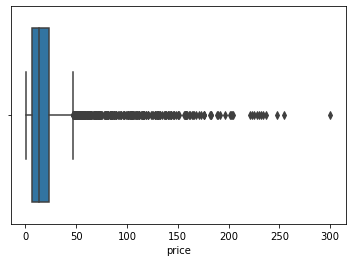

In [129]:
sns.boxplot(x=products_df.price)

In [142]:
products_df[products_df.price<median].count()

id_prod    1643
price      1643
categ      1643
Z-Score    1643
Z_score    1643
dtype: int64